In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import mu, get_velocity_profile, get_velocity_evolution, boxcarsmoothtrend
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [3]:
# output = vice.output("../outputs/linear/dvdr-0p05")
outputs = [
    # "../outputs/potential-well-deepening/gamma0p1",
    # "../outputs/potential-well-deepening/gamma0p3",
    # "../outputs/constant/vgas-0p5-fine",
    "../outputs/constant/vgas-0p5",
    # "../outputs/constant/vgas-0p5-dr0p2",
    # "../outputs/constant/vgas-0p5-coarse"
    "../outputs/constant/vgas-1",
#     "../outputs/linear/dvdr-0p02",
#     "../outputs/linear/dvdr-0p05",
    # "../outputs/angular-momentum-dilution/betaphiin0p7",
    # "../outputs/angular-momentum-dilution/betaphiin0p8"
]
outputs = [vice.output(name) for name in outputs]

/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


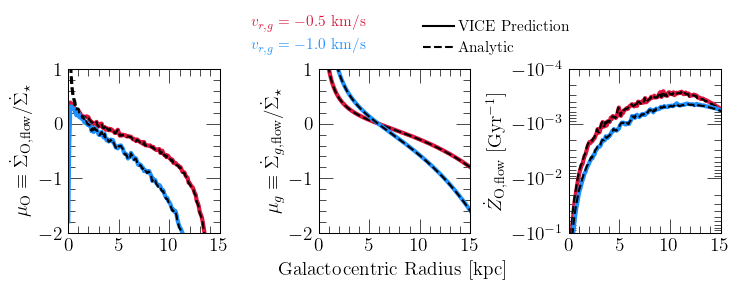

In [46]:
# COLORS = ["crimson", "black", "dodgerblue"]
COLORS = ["crimson", "dodgerblue"]
LABELS = [
#     r"$-0.02$ Gyr$^{-1}$",
#     r"$-0.05$ Gyr$^{-1}$"
    # r"$\gamma = 0.1$",
    # r"$\gamma = 0.3$"=
    r"$v_{r,g} = -0.5$ km/s",
    # r"$\delta R = 0.2$ kpc"
    r"$v_{r,g} = -1.0$ km/s"
]
ZONE_WIDTH = [0.1, 0.1, 0.1]

fig = plt.figure(figsize = (7.5, 3))
ax1 = fig.add_subplot(131)
ax1.set_ylabel(r"$\mu_\text{O} \equiv \dot \Sigma_\text{O,flow} / \dot \Sigma_\star$")
ax1.set_xlim([0, 15])
ax1.set_xticks([0, 5, 10, 15])
ax1.set_ylim([-2, 1])
# ax1.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])

ax2 = fig.add_subplot(132)
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
ax2.set_ylabel(r"$\mu_g \equiv \dot \Sigma_{g,\text{flow}} / \dot \Sigma_\star$")
ax2.set_xlim([0, 15])
ax2.set_xticks([0, 5, 10, 15])
ax2.set_ylim([-2, 1])
# ax2.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])

ax3 = fig.add_subplot(133)
ax3.set_ylabel(r"$\dot Z_\text{O,flow}$ [Gyr$^{-1}$]")
ax3.set_xlim([0, 12])
ax3.set_ylim([1.e-4, 0.1])
ax3.set_xticks([0, 5, 10, 15])
ax3.set_yscale("log")

kwargs = {
    "c": named_colors()["black"],
    "label": "VICE Prediction"
}
line1 = ax2.plot([0, 1], [0, 1], **kwargs)[0]
kwargs["linestyle"] = "--"
kwargs["label"] = "Analytic"
line2 = ax2.plot([0, 1], [0, 1], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 2,
    "bbox_to_anchor": (0.6, 1.0),
    "fontsize": 11
}
leg = ax2.legend(**kwargs)
ax2.add_artist(leg)
line1.remove()
line2.remove()


def numerical_mu_o(output, lookback, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii, vgas = get_velocity_profile(output, lookback)
    n_zones = len(output.zones.keys())
    dt = output.zones["zone0"].history["time"][1] - output.zones["zone0"].history["time"][0]
    mu = []
    for i in range(n_zones):
        radius = i * zone_width
        mdotflow = 0
        if i - 1 and vgas[i - 1] > 0:
            areafrac = radius**2 - (radius - vgas[i - 1] * dt)**2
            areafrac /= radius**2 - (radius - zone_width)**2
            mdotflow += output.zones["zone%d" % (i - 1)].history["mass(o)"][idx] * areafrac
        else: pass
        if vgas[i] < 0:
            areafrac = (radius - vgas[i] * dt)**2 - radius**2
            areafrac /= (radius + zone_width)**2 - radius**2
            mdotflow -= output.zones["zone%d" % (i)].history["mass(o)"][idx] * areafrac
        else:
            areafrac = (radius + zone_width)**2 - (radius + vgas[i] * dt)**2
            areafrac /= (radius + zone_width)**2 - radius**2
            mdotflow -= output.zones["zone%d" % (i)].history["mass(o)"][idx] * areafrac
        if i + 1 < n_zones - 1 and vgas[i + 1] < 0:
            areafrac = (radius + zone_width - vgas[i + 1] * dt)**2 - (radius + zone_width)**2
            areafrac /= (radius + 2 * zone_width)**2 - (radius + zone_width)**2
            mdotflow += output.zones["zone%d" % (i + 1)].history["mass(o)"][idx] * areafrac
        else: pass
        mdotflow /= dt
        Z = output.zones["zone%d" % (i)].history["z(o)"][idx]
        sfr = output.zones["zone%d" % (i)].history["sfr"][idx] * 1.e9
        if sfr:
            mu.append(mdotflow / (Z * sfr))
        else:
            mu.append(float("inf"))
    return [radii, mu]


def numerical_mu_gas(output, lookback, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii, vgas = get_velocity_profile(output, lookback)
    n_zones = len(output.zones.keys())
    dt = output.zones["zone0"].history["time"][1] - output.zones["zone0"].history["time"][0]
    mu = []
    for i in range(n_zones):
        radius = i * zone_width
        mdotflow = 0
        if i - 1 and vgas[i - 1] > 0:
            areafrac = radius**2 - (radius - vgas[i - 1] * dt)**2
            areafrac /= radius**2 - (radius - zone_width)**2
            mdotflow += output.zones["zone%d" % (i - 1)].history["mgas"][idx] * areafrac
        else: pass
        if vgas[i] < 0:
            areafrac = (radius - vgas[i] * dt)**2 - radius**2
            areafrac /= (radius + zone_width)**2 - radius**2
            mdotflow -= output.zones["zone%d" % (i)].history["mgas"][idx] * areafrac
        else:
            areafrac = (radius + zone_width)**2 - (radius + vgas[i] * dt)**2
            areafrac /= (radius + zone_width)**2 - radius**2
            mdotflow -= output.zones["zone%d" % (i)].history["mgas"][idx] * areafrac
        if i + 1 < n_zones - 1 and vgas[i + 1] < 0:
            areafrac = (radius + zone_width - vgas[i + 1] * dt)**2 - (radius + zone_width)**2
            areafrac /= (radius + 2 * zone_width)**2 - (radius + zone_width)**2
            mdotflow += output.zones["zone%d" % (i + 1)].history["mgas"][idx] * areafrac
        else: pass
        mdotflow /= dt
        sfr = output.zones["zone%d" % (i)].history["sfr"][idx] * 1.e9
        if sfr:
            mu.append(mdotflow / sfr)
        else:
            mu.append(float("inf"))
    return [radii, mu]


def numerical_zdotflow(output, lookback, mu_g, mu_o, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    zdotflow = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
        else:
            zdotflow.append(0)
            continue
        zdotflow.append(zone.history["z(o)"][idx] / taustar * (mu_o[i] - mu_g[i]))
    return [radii, zdotflow]


def analytic_zdotflow(output, lookback, zone_width = 0.1):
    radii, vgas = get_velocity_profile(output, lookback)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    zdotflow = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        neighbor = output.zones["zone%d" % (i + 1)]
        dzdr = neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]
        dzdr /= radii[i + 1] - radii[i]
        zdotflow.append(-vgas[i] * dzdr)
    return [radii[:-1], zdotflow]


def plot_predictions(ax_o, ax_g, ax_z, output, lookback, zone_width = 0.1, **kwargs):
    radii, mu_o = numerical_mu_o(output, lookback, zone_width = zone_width)
    ax_o.plot(radii, mu_o, **kwargs)
    radii, mu_g = numerical_mu_gas(output, lookback, zone_width = zone_width)
    # ax_g.plot(radii, boxcarsmoothtrend(radii, mu_g, window = 5), **kwargs)
    ax_g.plot(radii, mu_g, **kwargs)
    radii, zdot = numerical_zdotflow(output, lookback, mu_g, mu_o, zone_width = 0.1)
    # ax_z.plot(radii, boxcarsmoothtrend(radii, [-z for z in zdot], window = 5), **kwargs)
    ax_z.plot(radii, [-z for z in zdot], **kwargs)
    radii, mu_g, mu_o = mu(output, lookback, zone_width = zone_width)
    if "label" in kwargs.keys(): kwargs["label"] = None
    kwargs["linewidth"] = 1.5
    kwargs["c"] = named_colors()["black"]
    kwargs["linestyle"] = "--"
    ax_o.plot(radii[:-1], mu_o, **kwargs)
    ax_g.plot(radii[:-1], mu_g, **kwargs)
    radii, zdot = analytic_zdotflow(output, lookback, zone_width = zone_width)
    ax_z.plot(radii, [-z for z in zdot], **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i],
        "linewidth": 3
    }
    plot_predictions(ax1, ax2, ax3, outputs[i], 0, zone_width = ZONE_WIDTH[i], **kwargs)

# kwargs = {
#     "loc": mpl_loc("upper right"),
#     # "bbox_to_anchor": (0.98, 0.3),
#     "handlelength": 0,
#     "fontsize": 11
# }
# leg = ax2.legend(**kwargs)
# fancy_legend(leg, COLORS)
kwargs = {
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
    "fontsize": 11,
    "bbox_to_anchor": (0.4, 1.0)
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.65)
negative_log(ax3)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./zdotflow/analytic-vs-numeric.%s" % (ext), **kwargs)
plt.show()

In [ ]:
# output = vice.output("../outputs/linear/dvdr-0p08")
outputs = [
    "../outputs/constant/vgas-0",
    "../outputs/linear/dvdr-0p02",
    "../outputs/linear/dvdr-0p05",
    "../outputs/linear/dvdr-0p08"
#     "../outputs/constant/vgas-0p5"
#     "../outputs/river/test-coarse",
#     "../outputs/river/test",
#     "../outputs/river/test-fine"
# #     "../outputs/amd/test"
]
outputs = [vice.output(_) for _ in outputs]

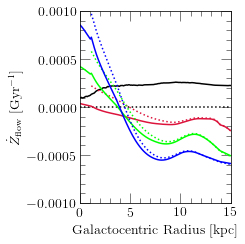

In [26]:
# LOOKBACKS = [0, 2, 4, 6, 8, 10]
# COLORS = ["black", "crimson", "gold", "lime", "blue", "darkviolet"]
# LOOKBACKS = [0]
# COLORS = ["black"]
COLORS = ["black", "crimson", "lime", "blue"]
N_RADII = 150

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
# ax.set_xlabel(r"Lookback Time [Gyr]")
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot Z_\text{flow}$ [Gyr$^{-1}$]")
ax.set_xlim([0, 15])
# ax.set_ylim([-0.0015, 0.0005])
# ax.set_xlim([5, 10])
ax.set_ylim([-0.001, 0.001])

def numerical_result1(lookback, output, zone_width = 0.1):
    zonetoprint = 20
    radii = [(i + 0.5) * zone_width for i in range(N_RADII)]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    zdotflow = []
    for i in range(N_RADII):
#         if i == zonetoprint: print("============================")
        zone = output.zones["zone%d" % (i)]
        dt = zone.history["time"][idx + 1] - zone.history["time"][idx]
        dzdt = (zone.history["z(o)"][idx + 1] - zone.history["z(o)"][idx]) / dt
#         if i == zonetoprint: print("dzdt = ", dzdt)
        zdot = dzdt
        if zone.history["sfr"][i]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
#             if eta != 0: print(output.name, radii[i], eta)
        else:
            zdotflow.append(0)
            continue
#         if i == zonetoprint: print("taustar = ", taustar)
#         if i == zonetoprint: print("O yield = ", zone.ccsne_yields['o'])
        zdot -= zone.ccsne_yields['o'] / taustar
#         zdot += zone.history["z(o)"][idx] * 1.e9 * zone.history["ifr"][idx] / zone.history["mgas"][idx]
        dlnmgdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        dlnmgdt /= zone.history["mgas"][idx] * dt
#         if i == zonetoprint: print("dlnmgdt = ", dlnmgdt)
#         eta = zone.history["eta_0"][idx]
        recycling = zone.history["R_eff"][idx]
        zdot += zone.history["z(o)"][idx] / taustar * (
            1 + eta - recycling + taustar * dlnmgdt)
#         if i == zonetoprint: print("zdot = ", zdot)
        zdotflow.append(zdot)
    return [radii[:N_RADII], zdotflow]

def numerical_result2(lookback, output, zone_width = 0.1):
    radii = [(i + 0.5) * zone_width for i in range(N_RADII)]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    zdotflow = []
    for i in range(N_RADII):
        zone = output.zones["zone%d" % (i)]
        dt = zone.history["time"][idx + 1] - zone.history["time"][idx]
        dodt = (zone.history["mass(o)"][idx + 1] - zone.history["mass(o)"][idx]) / dt
        dmgdt = (zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]) / dt
        if zone.history["sfr"][idx]:
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            eta = 0
#         eta = zone.history["eta_0"][idx]
        recycling = zone.history["R_eff"][idx]
        x = 1.e9 * zone.history["sfr"][idx] * (1 + eta - recycling)
        
        mdoto_flow = dodt
        mdoto_flow -= zone.ccsne_yields["o"] * zone.history["sfr"][idx] * 1.e9
        mdoto_flow += zone.history["z(o)"][idx] * x
        
        mdotg_flow = dmgdt
        mdotg_flow -= zone.history["ifr"][idx] * 1.e9
        mdotg_flow += x
        
        mgas = zone.history["mgas"][idx]
        zdotflow.append(mdoto_flow / mgas - zone.history["z(o)"][idx] * mdotg_flow / mgas)
    return [radii[:N_RADII], zdotflow]

def analytic_expectation(lookback, output, zone_width = 0.1):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_g, mu_o = mu(output, lookback, zone_width = zone_width)
    else:
        radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
        mu_g = mu_o = len(radii) * [0.]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    zdotflow = []
    for i in range(N_RADII):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
        else:
            taustar = float("nan")
        zdotflow.append(zone.history["z(o)"][idx] / taustar * mu_o[i])
    return [radii[:N_RADII], zdotflow]


# def analytic_expectation(lookback, output, zone_width = 0.1):
#     if os.path.exists("%s_gasvelocities.out" % (output.name)):
#         radii, vgas = get_velocity_profile(output, lookback)
#     else:
#         radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
#         vgas = len(radii) * [0.]
#     diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
#     idx = diff.index(min(diff))
#     zdotflow = []
#     for i in range(N_RADII):
#         zone = output.zones["zone%d" % (i)]
#         neighbor = output.zones["zone%d" % (i + 1)]
#         dzdr = (neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]) / zone_width
#         zdotflow.append(-vgas[i] * dzdr)
#     return [radii[:N_RADII], zdotflow]

def plot_comparison(lookback, output, zone_width = 0.1, **kwargs):
    radii, numeric = numerical_result1(lookback, output, zone_width = zone_width)
    _, analytic = analytic_expectation(lookback, output, zone_width = zone_width)
#     _, analytic = numerical_result2(lookback, output, zone_width = zone_width)
#     analytic = [(a + n) / 2 for a, n in zip(analytic, numeric)]
    ax.plot(radii, boxcarsmoothtrend(radii, numeric, window = 10), linestyle = "-", **kwargs) 
    ax.plot(radii, boxcarsmoothtrend(radii, analytic, window = 10), linestyle = ":", **kwargs)

# plot_comparison(2, output, c = named_colors()["black"])
# for i in range(len(LOOKBACKS)):
#     kwargs = {"c": named_colors()[COLORS[i]]}
#     plot_comparison(LOOKBACKS[i], output, **kwargs)
for i in range(len(outputs)):
    kwargs = {"c": named_colors()[COLORS[i]]}
    plot_comparison(8, outputs[i], **kwargs)

# for l in [0, 1, 2, 3, 4]:
#     kwargs = {"c": named_colors()[COLORS[l]]}
#     plot_comparison(l, outputs[-1], **kwargs)

plt.tight_layout()
plt.show()